<a href="https://colab.research.google.com/github/gguex/ISH_ressources_cours_ML/blob/main/T12_bert_finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP 12 : BERT fine-tuning

Dans ce TP, nous allons construire un modèle d'analyse des sentiments avec comme base un modèle BERT pré-entrainé. Nous allons ajouter une couche entièrement connectée à la sortie (du premier token) d'un modèle BERT, projetant le vecteur de contexte de BERT sur un seul neurone sensé représenter le log-odd de la séquence d'appartenir à la classe "sentiment positif".

Pour entrainer notre modèle, nous allons utiliser le jeu de données "Large Movie Review Dataset" (https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews), qui contient 50'000 évaluations de films faites par des utilisateurs sur IMDB. Ces reviews ont une annotation comme étant positives ou négatives.

Notre module d'analyse des sentiments va ensuite servir (même si l'entrainement sur des évaluations de films est discutable pour cette utilisation) à évaluer le sentiment positif/négatif qui se dégage à l'intérieur de chaque livre des Misérables.

Le modèle BERT pré-entrainé sera issu de https://huggingface.co/, où l'on peut trouver une grande quantité de modèles pré-entrainés. Ces modèles se téléchargent et s'utilisent généralement en utilisant la librairie `transformers`, qu'il faut prélablement installer.

In [ ]:
!pip install -qq transformers

     |████████████████████████████████| 5.8 MB 30.9 MB/s 
     |████████████████████████████████| 182 kB 87.2 MB/s 
     |████████████████████████████████| 7.6 MB 62.4 MB/s 


On va utiliser les librairies suivantes :

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import transformers
from transformers import BertModel, BertTokenizer, \
  get_linear_schedule_with_warmup
from tqdm import tqdm

Et nous allons utiliser l'accélération graphique, si elle est disponible : 

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## 1. Construction et finetuning du modèle

Avant de construire notre modèle, regardons nos données. On les charge et les affiche. La colonne "review" contient la critique, et la colonne "sentiment" l'appréciation, qui peut être "positive" ou "negative". Il s'agira de traduire ces deux colonnes dans des données utilisables par notre modèle. Nous y reviendrons après avoir examiné le modèle que nous allons utiliser.

In [ ]:
data_path = "/content/drive/MyDrive/Colab Notebooks/" \
              "ml_data/TP12/IMDB Dataset.csv"
data = pd.read_csv(data_path)
data

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


Après avoir trouvé un modèle qui semble convenir sur https://huggingface.co/, nous pouvons sauvegarder son nom dans une variable. Ici deux modèles sont suggérés :

* `"bert-base-uncased"` : le modèle qui est le plus fréquemment utilisé lorsque l'on utilise BERT, mais qui est relativement volumineux.
* `"prajjwal1/bert-mini"` : un modèle miniature de BERT, permettant des calculs plus rapides au détriment d'une moins bonne représentation des séquences d'entrée.

Vous pouvez décommenter le modèle qui vous convient, ou en trouver encore un autre. Les deux modèles sont "uncased", c'est-à-dire qu'ils ne prennent pas en compte les majuscules.

In [ ]:
#model_name = "prajjwal1/bert-mini"
model_name = "bert-base-uncased"

Les modèles de la librairie `transformers` proposent des tokenisateurs associés, permettant ainsi de pré-traiter les données textuelles de manière à les rendre compatible avec les entrées attendues. Nous allons charger le tokenisateur de type BERT basé sur le nom de notre modèle. 

In [ ]:
tokenizer = BertTokenizer.from_pretrained(model_name)

Regardons quelques opérations qu'il est possible d'effectuer avec cet objet, tel que la séparation et la transformation en identifiants numériques d'une chaine de caractères.

In [ ]:
example_text = "We are going to train a model, for sentiment classification!"
tokens = tokenizer.tokenize(example_text)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(example_text)
print(tokens)
print(token_ids)

We are going to train a model, for sentiment classification!
['we', 'are', 'going', 'to', 'train', 'a', 'model', ',', 'for', 'sentiment', 'classification', '!']
[2057, 2024, 2183, 2000, 3345, 1037, 2944, 1010, 2005, 15792, 5579, 999]


La méthode `encode_plus()` permet un traitement plus complet d'une chaine de caractères, en donnant non seulement la traduction en identifiants numériques des différents tokens, mais aussi le masque pour le méchanisme d'attention. Différentes options sont possibles, telles que la longueur maximale des séquences (`max_length=32`) et le type de tenseurs à donner (tenseurs de Pytorch avec `return_tensors="pt"`).

In [ ]:
encoding = tokenizer.encode_plus(
    example_text, 
    truncation=True,
    max_length=32,
    add_special_tokens=True,
    return_token_type_ids=False,
    padding="max_length",
    return_attention_mask=True,
    return_tensors="pt"
)
print(encoding["input_ids"])
print(encoding["attention_mask"])

tensor([[  101,  2057,  2024,  2183,  2000,  3345,  1037,  2944,  1010,  2005,
         15792,  5579,   999,   102,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])


Cette méthode nous permet donc de construire une transformation que nous allons utiliser sur notre dataset, où l'on précise la longueur maximale des séquences et le tokenisateur à utiliser.

In [ ]:
def my_transform(text, tokenizer, max_length):

  # L'encodage
  encoding = tokenizer.encode_plus(
      text,
      truncation=True,
      max_length=max_length,
      add_special_tokens=True,
      return_token_type_ids=False,
      padding="max_length",
      return_attention_mask=True,
      return_tensors="pt",   
  )
  # Retour de l'encodage et du masque
  return encoding["input_ids"].flatten(), encoding["attention_mask"].flatten()

Il est temps de créer notre classe héritée de `torch.utils.data.Dataset`. Nous transformons les sorties en valeurs numériques (avec 1 = "positive", 0 = "negative"), puis en array numpy. Lorsqu'un élément du dataset est demandé, nous appliquons la transformation (donnée en argument) et transformons la sortie en tenseur.

In [ ]:
class MyDataset(Dataset):

  # Constructeur
  def __init__(self, data_path, transform, tokenizer, sent_len):
    # On charge les données
    df = pd.read_csv(data_path)
    self.inputs = df.review.to_numpy()
    self.probs = (df.sentiment == "positive").to_numpy()
    self.transform = transform
    self.tokenizer = tokenizer
    self.sent_len = sent_len

  # Longueur
  def __len__(self):
    return len(self.probs)

  # Un élément
  def __getitem__(self, index):
    input = self.transform(str(self.inputs[index]), 
                           self.tokenizer, 
                           self.sent_len)
    prob = torch.tensor(self.probs[index], dtype=torch.float32)
    return input, prob

Créons une instance de notre classe pour notre dataset, et regardons un élément. Une séquence d'entiers et le masque sont donnés comme éléments d'entrée.

In [ ]:
max_length = 512
data_path = "/content/drive/MyDrive/Colab Notebooks/" \
              "ml_data/TP12/IMDB Dataset.csv"
my_data = MyDataset(data_path, my_transform, tokenizer, max_length)
my_data[0]

((tensor([  101,  2028,  1997,  1996,  2060, 15814,  2038,  3855,  2008,  2044,
           3666,  2074,  1015, 11472,  2792,  2017,  1005,  2222,  2022, 13322,
           1012,  2027,  2024,  2157,  1010,  2004,  2023,  2003,  3599,  2054,
           3047,  2007,  2033,  1012,  1026,  7987,  1013,  1028,  1026,  7987,
           1013,  1028,  1996,  2034,  2518,  2008,  4930,  2033,  2055, 11472,
           2001,  2049, 24083,  1998,  4895, 10258,  2378,  8450,  5019,  1997,
           4808,  1010,  2029,  2275,  1999,  2157,  2013,  1996,  2773,  2175,
           1012,  3404,  2033,  1010,  2023,  2003,  2025,  1037,  2265,  2005,
           1996,  8143, 18627,  2030,  5199,  3593,  1012,  2023,  2265,  8005,
           2053, 17957,  2007, 12362,  2000,  5850,  1010,  3348,  2030,  4808,
           1012,  2049,  2003, 13076,  1010,  1999,  1996,  4438,  2224,  1997,
           1996,  2773,  1012,  1026,  7987,  1013,  1028,  1026,  7987,  1013,
           1028,  2009,  2003,  2170, 11

Séparons notre jeu de données en jeux d'entrainement, validation et test, avec les proportions 70% - 15% - 15%.

In [ ]:
valid_ratio = 0.15
test_ratio = 0.15
valid_size = int(valid_ratio * len(my_data))
test_size = int(test_ratio * len(my_data))
train_size = len(my_data) - valid_size - test_size
my_data_train, my_data_valid, my_data_test = \
  random_split(my_data, [train_size, valid_size, test_size])
print(train_size, valid_size, test_size)

35000 7500 7500


Créons les Dataloaders, avec batch de 32. Le paramètre `num_workers` nous permet d'attribuer plus de processus chargés d'envoyer les données.

In [ ]:
batch_size = 32
train_loader = DataLoader(my_data_train, batch_size, num_workers=2)
valid_loader = DataLoader(my_data_valid, batch_size, num_workers=2)
test_loader = DataLoader(my_data_test, batch_size, num_workers=2)

La classe `transformers.BertModel` nous permet des créer des instances de modèles pré-entrainés, grâce à sa méthode `from_pretrained()`, à partir d'un nom de modèle Hugging Face. Le modèle est téchargé et mis en mémoire.

In [ ]:
bert_model = BertModel.from_pretrained(model_name)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


En passant un exemple de notre jeu de données dans ce modèle, nous pouvons voir la sortie, qui est constituée de deux éléments `last_hidden_state` et `pooler_output`. Ces deux sorties contiennent :

* `last_hidden_state` : les sorties cachées de la dernière couche du modèle, avec un vecteur d'une taille définie (par la modèle) pour chaque token d'entrée.
* `pooler_output` : le vecteur caché du premier élément de la phrase, correspondant au token [CLS], et qui sert de résumé pour toute la phrase.

In [ ]:
input, _ = my_data[0]
bert_output = bert_model(input_ids=input[0].unsqueeze(0), 
                         attention_mask=input[1].unsqueeze(0))
bert_output.keys()

odict_keys(['last_hidden_state', 'pooler_output'])

In [ ]:
print(bert_output["last_hidden_state"].shape)
print(bert_output["pooler_output"].shape)

torch.Size([1, 512, 768])
torch.Size([1, 768])


Nous allons maintenant créer un modèle qui consiste en :
* Un modèle pré-entrainé de type BERT.
* Une couche entièrement connectée qui prend le premier état caché de la sortie du modèle BERT (avec dropout) et l'envoie sur une seule sortie, nous servant ainsi de log-odds pour le sentiment positif.

Notez que la taille du vecteur caché peut s'obtenir en utilisant l'attribut `bert.config.hidden_size`, permettant ainsi de définir le bon nombre de neurones dans la couche entièrement connectée.

In [ ]:
class SentClassifier(nn.Module):

  def __init__(self, bert_model_name):
    super(SentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(bert_model_name)
    self.drop = nn.Dropout(p=0.3)
    self.full = nn.Linear(self.bert.config.hidden_size, 1)

  def forward(self, input_ids, attention_mask):
    bert_output = self.bert(input_ids, attention_mask)
    dropout = self.drop(bert_output["pooler_output"])
    logits = self.full(dropout)
    return logits

Vérifions que notre modèle fonctionne correctement en lui envoyant une entrée de notre jeu de données.

In [ ]:
my_model = SentClassifier(model_name)
my_model.to(device)
my_model(input[0].unsqueeze(0).to(device), input[1].unsqueeze(0).to(device))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tensor([[-0.0851]], device='cuda:0', grad_fn=<AddmmBackward0>)

L'entrainement du modèle va s'effectuer d'une manière légèrement plus complexe que les dernières fois. Nous allons utiliser ici un **ordonnanceur** pour le taux d'apprentissage, avec une instance de classe obtenu avec la fonction `transformers.get_linear_schedule_with_warmup()`. Cette instance permet de faire varier le taux d'apprentissage en fonction des itérations. Le taux d'apprentissage commence à 0, monte rapidement jusqu'à sa valeur maximale définie dans l'optimisateur, puis diminue lentement jusqu'à le nombre d'itérations maximal (`len(train_loader) * n_epochs`). Cette procédure permet de chercher plus efficacement un minimum dans la fonctionnelle. Pour en savoir plus, voir https://huggingface.co/docs/transformers/main_classes/optimizer_schedules#transformers.get_linear_schedule_with_warmup.optimizer. 

La fonction de perte est `torch.nn.BCEWithLogitsLoss()` qui permet de comparer une sortie entre un log-odd vs une valeur binaire.

In [ ]:
n_epochs = 10
optimizer = torch.optim.AdamW(my_model.parameters(), lr=2e-5)
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=len(train_loader) * n_epochs
)
loss_fn = nn.BCEWithLogitsLoss()

Nous allons aussi implémenter un arrêt prématuré dans notre entrainement. Pour cela, nous allons sauver le modèle (sous `checkpoint_path`) à chaque fois que celui-ci diminue la perte de validation, et nous arrêterons l'entrainement si la perte d'entrainement n'a pas diminué durant `patience` epochs. Il nous suffira de revenir au dernier modèle sauvé pour avoir celui qui présente les meilleurs performances de validation.

In [ ]:
patience = 3
checkpoint_path = "checkpoint.pt"

Nous allons maintenant effectuer l'entrainement. Vous pouvez lire les commentaires ci-dessous pour avoir les détails.

In [ ]:
# Valeur initiale de la perte minimale obtenue (artificiellement 
# élevée initialement) pour l'arrêt prématuré
lowest_valid_loss = 1e5
# Le conteur de patience
patience_counter = 0
# La boucle sur les epochs
for epoch in range(n_epochs):

  print(f"Epoch {epoch + 1}/{n_epochs}")

  # --- Training

  my_model.train()
  sum_train_loss = 0
  sum_train_acc = 0
  # La boucle sur le loader d'entrainement
  for (input_ids, masks), outputs in tqdm(train_loader):
    input_ids = input_ids.to(device)
    masks = masks.to(device)
    outputs = outputs.to(device).unsqueeze(1)

    optimizer.zero_grad()
    logits = my_model(input_ids, masks)
    loss = loss_fn(logits, outputs)
    loss.backward()
    # On procède ici au gradient clipping, pour être sur que celui-ci
    # ne déborde pas.
    nn.utils.clip_grad_norm_(my_model.parameters(), max_norm=1.0)
    # Notre optimisateur et notre ordonnanceur son mis à jour
    optimizer.step()
    scheduler.step()

    sum_train_loss += loss.detach().item()
    sum_train_acc += ((logits.flatten() > 0) == 
                      outputs.flatten()).detach().sum().item()

  # --- Validation

  my_model.eval()
  sum_valid_loss = 0
  sum_valid_acc = 0
  for (input_ids, masks), outputs in tqdm(valid_loader):
    input_ids = input_ids.to(device)
    masks = masks.to(device)
    outputs = outputs.to(device).unsqueeze(1)

    logits = my_model(input_ids, masks)
    loss = loss_fn(logits, outputs)

    sum_valid_loss += loss.detach()
    sum_valid_acc += ((logits.flatten() > 0) == 
                      outputs.flatten()).detach().sum().item()

  train_loss = sum_train_loss/len(train_loader)
  train_acc = sum_train_acc/len(train_loader.dataset)
  valid_loss = sum_valid_loss/len(valid_loader)
  valid_acc = sum_valid_acc/len(valid_loader.dataset)

  print(f"Train loss: {train_loss:.4f}, Valid loss: {valid_loss:.4f}")
  print(f"Train accuracy: {train_acc:.2%}, Valid accuracy: {valid_acc:.2%}")

  # --- Pour l'arrêt prématuré

  # Si la perte de validation est plus petite que la dernière enregistrée,
  # on effectue un checkpoint du modèle
  if valid_loss < lowest_valid_loss:
    print(f"***{valid_loss:.4f} < {lowest_valid_loss:.4f}, saving.***")
    torch.save({"model_state_dict": my_model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "scheduler_state_dict": scheduler.state_dict()},
               checkpoint_path)
    lowest_valid_loss = valid_loss
    patience_counter = 0
  # Sinon, on augmente le compteur de patience
  else:
    patience_counter += 1

  # Si le compteur de patience atteint la limite, on arrête l'entrainement
  if patience_counter >= patience:
    print("Early stopping")
    break

# On charge le dernier modèle sauvé
checkpoint_dict = torch.load(checkpoint_path, map_location=torch.device(device))
my_model.load_state_dict(checkpoint_dict["model_state_dict"])
optimizer.load_state_dict(checkpoint_dict["optimizer_state_dict"])
scheduler.load_state_dict(checkpoint_dict["scheduler_state_dict"])

Epoch 1/10


100%|██████████| 235/235 [00:51<00:00,  4.52it/s]


Train loss: 0.2348, Valid loss: 0.1879
Train accuracy: 90.47%, Valid accuracy: 93.28%
***0.1879 < 100000.0000, saving.***
Epoch 2/10


100%|██████████| 235/235 [00:51<00:00,  4.52it/s]


Train loss: 0.1253, Valid loss: 0.2005
Train accuracy: 95.96%, Valid accuracy: 93.93%
Epoch 3/10


100%|██████████| 235/235 [00:51<00:00,  4.52it/s]


Train loss: 0.0708, Valid loss: 0.2520
Train accuracy: 98.01%, Valid accuracy: 94.09%
Epoch 4/10


100%|██████████| 235/235 [00:51<00:00,  4.52it/s]


Train loss: 0.0490, Valid loss: 0.3095
Train accuracy: 98.79%, Valid accuracy: 94.03%
Early stopping


Effectuons maintenant l'évaluation du modèle sur le jeu de test. On va également sauver chaque sortie en terme de probabilité, afin de voir la répartition de ces dernières.

In [ ]:
my_model.eval()
sum_test_loss = 0
sum_test_acc = 0
real_sent = []
pred_sent = []
for (input_ids, masks), outputs in tqdm(test_loader):
  input_ids = input_ids.to(device)
  masks = masks.to(device)
  outputs = outputs.to(device).unsqueeze(1)

  logits = my_model(input_ids, masks).detach()
  loss = loss_fn(logits, outputs).detach()
  sum_test_acc += ((logits.flatten() > 0) == outputs.flatten()).sum().item()
  probs = torch.sigmoid(logits)

  real_sent.extend([real_prob.item() for real_prob in outputs.flatten()])
  pred_sent.extend([pred_prob.item() for pred_prob in probs.flatten()])
  sum_test_loss += loss.item()

print(f"\nLoss : {sum_test_loss/len(test_loader):.4f}")
print(f"Accuracy : {sum_test_acc/len(test_loader.dataset):.2%}")

100%|██████████| 235/235 [00:52<00:00,  4.49it/s]


Loss : 0.1769
Accuracy : 0.9383


On peut tracer les boxplots des probabilités prédites pour les critiques négatives et positives. Il y a quelques critiques (par rapport à la taille du jeu de test) avec une probabilité contre-intuitive par rapport à leur appréciation, mais la majorité semble concentré sur les pôles adéquats.

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


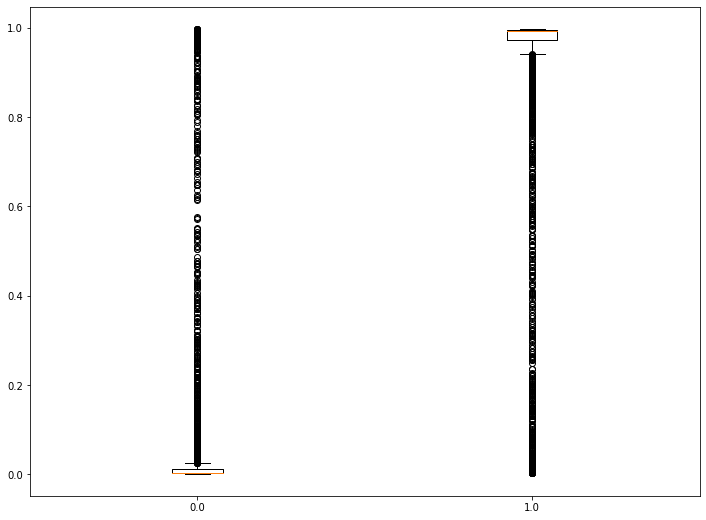

In [ ]:
real_sent = np.array(real_sent)
pred_sent = np.array(pred_sent)
unique_real_sent = list(set(real_sent))
binned_pred_sent = [np.array(pred_sent)[np.where(real_sent == sent)[0]]
                    for sent in unique_real_sent]

plt.rcParams["figure.figsize"] = [12, 9]
plt.boxplot(binned_pred_sent, positions=unique_real_sent)
plt.show()

On sauve maintenant le modèle dans le drive, afin de pouvoir l'utiliser dans la deuxième partie sans la phase d'entrainement.

In [ ]:
model_path = "/content/drive/MyDrive/Colab Notebooks/ml_data/" \
             "TP12/sent_analyser_bert_base.pt"
torch.save({"model_state_dict": my_model.state_dict(),
            "optimizer_tat_dict": optimizer.state_dict(),
            "scheduler_state_dict": scheduler.state_dict()},
            model_path)

---

## 2. Utilisation du modèle pour l'analyse des sentiments

Passons maintenant à la partie où nous allons utiliser notre modèle d'analyse des sentiments sur le corpus des Misérables.

Comme cette deuxième partie peut être utilisée de manière indépendante de la première partie, nous allons redéfinir ici plusieurs éléments, tout en rechargeant le modèle entrainé.

In [ ]:
# --- Le nom du modèle à charger

# model_name = "prajjwal1/bert-mini"
# model_path = "/content/drive/MyDrive/Colab Notebooks/ml_data/" \
#              "TP12/sent_analyser_bert_mini.pt"
model_name = "bert-base-uncased"
model_path = "/content/drive/MyDrive/Colab Notebooks/ml_data/" \
             "TP12/sent_analyser_bert_base.pt"

# --- La longueur maximale des séquences

max_length = 512

# --- Définition du modèle et chargement

class SentClassifier(nn.Module):

  def __init__(self, bert_model_name):
    super(SentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(bert_model_name)
    self.drop = nn.Dropout(p=0.3)
    self.full = nn.Linear(self.bert.config.hidden_size, 1)

  def forward(self, input_ids, attention_mask):
    bert_output = self.bert(input_ids, attention_mask)
    dropout = self.drop(bert_output["pooler_output"])
    logits = self.full(dropout)
    return logits

sent_classif = SentClassifier(model_name)
model_dict = torch.load(model_path, map_location=torch.device(device))
sent_classif.load_state_dict(model_dict["model_state_dict"])

# --- Le tokenisateur

tokenizer = BertTokenizer.from_pretrained(model_name)

# --- la transformation

def my_transform(text, tokenizer, max_length):
  # L'encodage
  encoding = tokenizer.encode_plus(text, truncation=True, max_length=max_length,
      add_special_tokens=True, return_token_type_ids=False, return_tensors="pt",
      return_attention_mask=True, padding="max_length")
  # Retour de l'encodage et du masque
  return encoding["input_ids"].flatten(), encoding["attention_mask"].flatten()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Définissons maintenant une classe héritée de `torch.utils.data.Dataset` qui permet de donner des entrées compatibles avec notre modèle à partir d'un livre de notre corpus. Pour cela, nous divisons notre livre en blocs, de au plus `max_length` tokens, et transformons ces blocs en tenseurs grâce à notre transformation.

In [ ]:
class MyDocument(Dataset):
    def __init__(self, file_path, tokenizer, max_length, transform):
        self.file_path = file_path
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.transform = transform

        with open(self.file_path, "r") as f:
          self.text = f.read()

        # On encode avec le tokenizer pour estimer le nombre de tokens
        tokens = self.tokenizer.encode_plus(self.text)["input_ids"]
        n_tokens = len(tokens)
        # Le nombre de blocs 
        n_blocs = int(n_tokens / max_length) + 1
        # Les blocs résultant (avec ids des tokens)
        id_blocs = np.array_split(tokens[1:-1], n_blocs)
        # On converti à nouveau en texte
        self.blocs = [" ".join(self.tokenizer.convert_ids_to_tokens(id_bloc)) 
                      for id_bloc in id_blocs]

    def __len__(self):
        return len(self.blocs)

    def __getitem__(self, idx):
        return self.transform(self.blocs[idx], self.tokenizer, self.max_length)

On teste notre classe Dataset avec le premier livre.

In [ ]:
file_path = "/content/drive/MyDrive/Colab Notebooks/ml_data/TP10/" \
            "by_book/book_01.txt"
doc_data = MyDocument(file_path, tokenizer, max_length, my_transform)

Token indices sequence length is longer than the specified maximum sequence length for this model (31641 > 512). Running this sequence through the model will result in indexing errors


L'entrée et le masque correspondant au premier bloc sont affichés.

In [ ]:
doc_data[0]

(tensor([  101,  1999, 10679,  1010,  1049,  1012,  2798,  1011,  8173,  1011,
         29316,  1001,  1001,  2310,  2078,  1001,  1001,  1057,  2026,  1001,
          1001, 15544,  2063,  1001,  1001,  1048,  2001,  3387,  1997,  1040,
          1517,  1517,  2002,  2001,  2019,  2214,  2158,  1997,  2055, 10920,
          1011,  2274,  2086,  1997,  2287,  1025,  2002,  2018,  4548,  1996,
          2156,  1997,  1040,  1517,  1517,  2144, 12518,  1012,  2348,  2023,
          6987,  2038,  2053,  4434,  3649,  2007,  1996,  2613,  9415,  1997,
          2054,  2057,  2024,  2055,  2000, 14396,  1010,  2009,  2097,  2025,
          2022,  3565,  1001,  1001, 13109,  1001,  1001,  1057,  3560,  1010,
          2065,  6414,  2005,  1996,  8739,  1997,  6635,  1001,  1001, 23384,
          1999,  2035,  2685,  1010,  2000,  5254,  2182,  1996,  2536, 11256,
          1998, 12629,  2029,  2018,  2042,  1999,  9141,  2055,  2032,  2013,
          1996,  2200,  2617,  2043,  2002,  3369,  

Regardons si nous pouvons passer une entrée dans notre modèle, pour voir si tout fonctionne.

In [ ]:
input, mask = doc_data[0]
sent_classif.eval()
sent_classif(input.unsqueeze(0), mask.unsqueeze(0))

tensor([[0.4101]], grad_fn=<AddmmBackward0>)

Nous créons maintenant une fonction qui prend une instance de notre classe Dataset en entrée et permet d'estimer le sentiment de chaque bloc.

In [ ]:
def get_sentiments(file_data, model, batch_size):
  file_data_loader = DataLoader(file_data, batch_size)

  file_sents = []
  model.eval()
  for inputs, masks in file_data_loader:
    logits = model(inputs, masks).detach()
    probs = torch.sigmoid(logits)
    file_sents.extend(probs.flatten().tolist())
  
  return file_sents

On va executer cette fonction sur tout notre corpus, et sauvegarder les sentiments prédits dans une liste (livre) de liste (blocs).

In [ ]:
corpus_path = "/content/drive/MyDrive/Colab Notebooks/ml_data/TP10/by_book"
batch_size = 64

file_names = os.listdir(corpus_path)
file_names.sort()

corpus_sents = []
for i, file_name in tqdm(enumerate(file_names)):

  file_path = f"{corpus_path}/{file_name}"
  file_data = MyDocument(file_path, tokenizer, max_length, my_transform)
  file_sents = get_sentiments(file_data, sent_classif, batch_size)

  corpus_sents.append(file_sents)

49it [06:41,  8.19s/it]


On affiche le sentiment calculé sur chaque bloc, avec une moyenne mobile sur une fenêtre de `ma_window_size`. De plus, les sentiments moyens de chaque livre et du corpus sont calculés.

Sentiment moyen total = 0.353


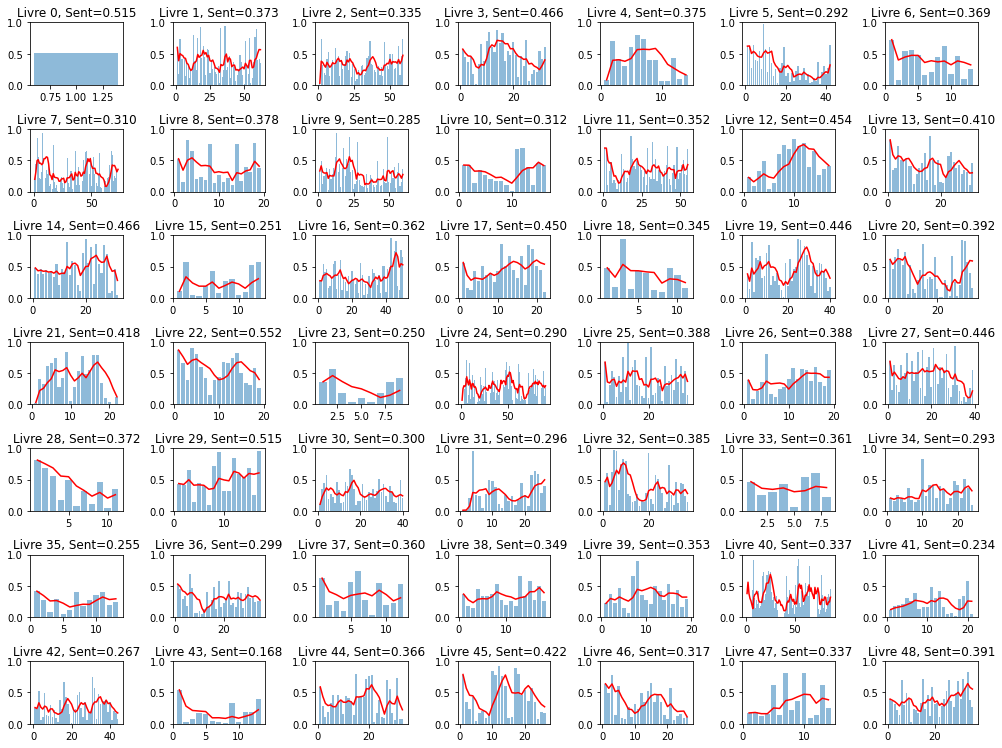

In [ ]:
ma_window_size = 5

nx_grid = int(np.sqrt(len(corpus_sents)))
ny_grid= int(np.ceil(len(corpus_sents) / nx_grid))
plt.rcParams["figure.figsize"] = [ny_grid*2, nx_grid*1.5]

fig = plt.figure()
grid_layout = GridSpec(nx_grid, ny_grid)

total_sent, total_part = 0, 0
for i, file_sents in enumerate(corpus_sents):

  # Pour calculer la moyenne mobile
  mov_avg_df = pd.Series(file_sents).rolling(ma_window_size, min_periods=1)
  mov_avg = mov_avg_df.mean().to_list()

  x_range = list(range(1, len(file_sents) + 1))

  ax = fig.add_subplot(grid_layout[i])
  ax.bar(x_range, file_sents, alpha=0.5)
  ax.plot(x_range, mov_avg, color="red")
  ax.set_ylim([0, 1])
  ax.set_title(f"Livre {i}, Sent={np.mean(file_sents):.3f}")

  # On fait la somme du sentiment et comptons le nombre de blocs
  total_sent += np.sum(file_sents)
  total_part += len(file_sents)

grid_layout.tight_layout(fig)

print(f"Sentiment moyen total = {total_sent/total_part:.3f}")

---